In [1]:
'''this notebook heavily refers to the post https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/'''

'this notebook heavily refers to the post https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/'

## Overview of Topic Modeling

Before using the topic modelling to explore our data set, let's first look at definition of Topic Modelling. (If you are not very fimilar with
the techniques about preprocessing, here is a separate notebook introducing these ideas.)

### What is topic modelling

Topic Modelling is a technique used in the Natrual Language Processing context to discover the latent semantic structures in the text, although it is very
tempting to think of it as a magic tool to extract the topic from the text, **topic modelling** actually has very specific definition and should be used properly.
Here we use the definition from the book *Speech and Language Processing*: topic modelling is used to induce sets of associated words from text using unsupervised learning. For example, this set of words {waiter, dishes, chef, plate} is associated and often appear at the same time in text.

More rigoriously, topic can be defined as the **probability distribution over words**

Another task which is easily confused with topic modelling is **text classification**, in that task, we need to assigne a label to a given text. For example, figure out if a poem is about history or religion. The main difference is that, in topic modelling, the output is a set of words which represent an unknown topic(e.g. {waiter, dishes ...}), while in text classification, the output is a single label(e.g. history)

### How to use topic modelling 

Topic modelling is very useful when it is used to provide some insight to the reader about a large amount of text, by looking at the output of the results, you can see how many potential topics are there, and then by looking at the words contained in each topic, you can have a vague idea for what this topic is about. 

### (Aside issue) Implementation of topic modelling

In this script, we use a common algorithm called *Latent Dirichlet Allocation,LDA* to implement Topic modelling, understand this method may require substantial math. background, but just in case anyone is interesting, I put the link to the original paper [here](http://www.robotics.stanford.edu/~ang/papers/jair03-lda.pdf)

## Content

In this notebook we did the following things:
- Import the library
- Preprocessing the text
    * Remove the stop words
    * Stemming the words
    * Create bigrams and trigrams from the words
- Apply topic modelling algorithm
- Explore the results of topic modelling
    * Using pyLDAvis to dynamically interact with the topic modelling results
    * Look at the topic modelling results from tables

### Loading the library

You may need to install the following library before importing to install this library just run the following code in the terminal
- gensim 
    - conda install -c anaconda gensim 
- nltk 
    - conda install -c anaconda nltk
- pyLDAvis
    - conda install -c conda-forge pyldavis 
    - or
    - conda install -c conda-forge/label/gcc7 pyldavis

Make sure you have anoconda in your computer!!!


In [2]:
import nltk
#nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#for Stemming
from nltk.stem.snowball import DanishStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\ljh\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import os,sys
parentPath = os.path.join(os.path.dirname(os.getcwd()),"tools")
sys.path.insert(0, parentPath)
from scripts_py import preprocessing as pre

yo uare sadfsaffsa		fsad


### Preprocessing

#### Prepare stopwords

we have a list of stop words from nltk library, but you can also have your own list of stop words as well

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('danish')
stop_words.extend(['paa','ved','saa','den'])

#### Select author and Read in the article of the author

You can select any author by  last name, the available name is the second column of ADL/metadata/metadata_adl.csv file

In [5]:
import codecs
def creat_file_list(author_name):
    """this function is used to get the list of articles of a given author"""
    file_list=['non']
    cwd=os.getcwd()
    parent_path = os.path.dirname(cwd)
    des_pos=os.path.join(parent_path,"ADL","metadata","metadata_adl.csv")
    fh=codecs.open(des_pos,'r','utf-8')
    for line in fh.readlines():
        L=line.split(",")
        if(re.search(author_name,L[1])):
            temp_string=L[0]+".txt"
            file_list.append(temp_string)
    return file_list[1:]
def read_articles(articles):
    """this function read in articles and return content"""
    data = list()
    for ele in articles:
        article = os.path.join(os.path.dirname(os.getcwd()),"ADL","plain",ele)
        with open(article, encoding ="utf-8") as f:
            lines = f.readlines()
        data.append( ' '.join(lines))
    return data

The code below read all the articles of Grundtvig and store them into data

In [6]:
author = "Grundtvig"
articles = creat_file_list(author)
data = read_articles(articles)

If you don't want all the articles but only specifc articles, you can specify in the following way

In [7]:
#articles = ["aare01val_workid69870.txt","aakjaer01val_workid55565.txt","aakjaer01val_workid55662.txt" ,"aakjaer01val_workid55881.txt"]
#data = read_articles(articles)

#### Cleaning the text
Tokenize the words and remove non-alpha symbol

In [8]:
nalpha_content = [pre.re_nalpha(ele) for ele in data]
tokenized_content = [pre.tokenizer(ele) for ele in nalpha_content]

Remove stop words

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [10]:
data_words_nostops=remove_stopwords(tokenized_content)

### Apply lda algorithm to obtain the result

#### Form bigrams from the text

We first construct faster model(a model which could capture the common phrase in the corpus) then apply this model to obtain bigram words.
The way to do this is a little bit diffcult to understand, but the key is to understand what *gensim.models.Phrases()* , this function, is doing. This function will train a model from our text, and resulting model using the vector representation of the words to find the meaningful bigram and store these bigram in the model. Details could be found [here](https://radimrehurek.com/gensim/models/phrases.html)

In [11]:
bigram = gensim.models.Phrases(tokenized_content, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
def make_bigrams(texts):
    """this function will use our model to find the bigram in each sentence"""
    return [bigram_mod[doc] for doc in texts]
#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def stemmer(wordList):
    """stemming the words for later processing"""
    stemmer = DanishStemmer()
    return [stemmer.stem(tempWord) for tempWord in wordList]

Get the bigram and stem obtained bigrams

In [13]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_stemmed = [stemmer(ele) for ele in data_words_bigrams]
data_stemmed=remove_stopwords(data_stemmed)

Create informative measurement from the raw text, which are used by the LDA training function

In [14]:
#Create Dictionary wich contains a mapping between normalized words and their integer ids
id2word = corpora.Dictionary(data_stemmed)

In [15]:
# Term Document Frequency
texts = data_stemmed
corpus = [id2word.doc2bow(text) for text in texts]

#### Get lda model 

Tuning of hyper parameter(e.g. num_topics, update_every, etc.) is essential for the quality of the reuslting model, modeling training could last for very long time depending on the length of the text

In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
%store lda_model

Stored 'lda_model' (LdaModel)


### Model exploration

#### A brief looking at the obtained results

In [18]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"gud" + 0.011*"liv" + 0.011*"ei" + 0.010*"aand" + 0.009*"dit" + '
  '0.009*"død" + 0.007*"kun" + 0.007*"ord" + 0.006*"verd" + 0.006*"evig"'),
 (1,
  '0.013*"kan" + 0.010*"aand" + 0.010*"kirk" + 0.009*"kun" + 0.008*"maa" + '
  '0.008*"naar" + 0.007*"ord" + 0.007*"hel" + 0.007*"tro" + 0.006*"gud"'),
 (2,
  '0.007*"kong" + 0.007*"kun" + 0.007*"stor" + 0.006*"hel" + 0.006*"rom" + '
  '0.006*"kom" + 0.005*"ogsaa" + 0.005*"vel" + 0.005*"baad" + 0.005*"vild"'),
 (3,
  '0.013*"kong" + 0.010*"ei" + 0.005*"kom" + 0.005*"dannemark" + 0.003*"kun" + '
  '0.003*"gaml" + 0.003*"søn" + 0.003*"ord" + 0.003*"sagd" + 0.003*"dag"'),
 (4,
  '0.001*"jordensaa" + 0.001*"rethan" + 0.001*"tidsom" + 0.001*"givetat" + '
  '0.001*"tilbage" + 0.001*"sønjeg" + 0.001*"svigei" + 0.001*"saamed" + '
  '0.001*"letsom" + 0.001*"matthisonhans"'),
 (5,
  '0.017*"ei" + 0.011*"gud" + 0.007*"dit" + 0.006*"kun" + 0.005*"mon" + '
  '0.004*"kan" + 0.004*"ord" + 0.004*"gaml" + 0.003*"kirk" + 0.003*"maa"'),
 (6,
  '0

#### The following is two standards to evaluate the quality of our results

Perplexity measures the prediction ability of language model, a smaller value of perplexity indicates a better quality of our model. And coherence score is specifically designed for evaluating the results of topic modelling, bigger value of coherence Score indicate a better model.The paper about cohenrent score can be find [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_stemmed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.747952069828413

Coherence Score:  0.4597481856292293


#### Interact with the results dynamically

This is powerful tool, and you can use it to explore the topic modelling results

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\ljh\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.352767 -0.104253       1        1  38.209961
1     -0.314489 -0.133772       2        1  18.816734
2     -0.271213 -0.154292       3        1  16.645283
18    -0.159242  0.052571       4        1   4.235795
14    -0.204852  0.131485       5        1   3.653514
3     -0.139740  0.050386       6        1   3.598052
5     -0.122729  0.150840       7        1   3.558576
0     -0.171757  0.178774       8        1   3.416647
12     0.064697 -0.181210       9        1   1.791397
10     0.094995 -0.072366      10        1   1.775762
8     -0.039236  0.144822      11        1   1.234161
9      0.098753 -0.078633      12        1   1.195970
6      0.185640  0.009608      13        1   0.600555
19     0.187372 -0.003058      14        1   0.343762
17     0.195346 -0.001124      15        1   0.218407
16     0.191866 -0.001324      16        1   0.203049
13     0.193317  0.002008      17        1   0.193561
7      0.188883  0.003125      18        1   0.145947
15     0.188013  0.002730      19        1   0.083439
4      0.187143  0.003684      20        1   0.079421, topic_info=      Category          Freq             Term         Total  loglift  logprob
term                                                                         
10     Default   9434.000000               ei   9434.000000  30.0000  30.0000
1835   Default   2059.000000            dansk   2059.000000  29.0000  29.0000
193    Default   6606.000000              gud   6606.000000  28.0000  28.0000
74     Default   4814.000000              ord   4814.000000  27.0000  27.0000
116    Default   5774.000000             aand   5774.000000  26.0000  26.0000
44     Default  10871.000000              kan  10871.000000  25.0000  25.0000
748    Default   3873.000000              liv   3873.000000  24.0000  24.0000
50     Default   3225.000000             kong   3225.000000  23.0000  23.0000
52     Default   9854.000000              kun   9854.000000  22.0000  22.0000
8      Default   3270.000000              død   3270.000000  21.0000  21.0000
397    Default   2415.000000            hjert   2415.000000  20.0000  20.0000
149    Default   1428.000000          danmark   1428.000000  19.0000  19.0000
108    Default   2927.000000             verd   2927.000000  18.0000  18.0000
256    Default   1810.000000             nord   1810.000000  17.0000  17.0000
1070   Default   3125.000000             kirk   3125.000000  16.0000  16.0000
22143  Default    736.000000              dam    736.000000  15.0000  15.0000
3673   Default    921.000000            krist    921.000000  14.0000  14.0000
0      Default   2483.000000               al   2483.000000  13.0000  13.0000
384    Default   2590.000000             giør   2590.000000  12.0000  12.0000
901    Default   6005.000000              maa   6005.000000  11.0000  11.0000
146    Default   3230.000000              dag   3230.000000  10.0000  10.0000
409    Default   5233.000000              kom   5233.000000   9.0000   9.0000
60     Default   1810.000000              lys   1810.000000   8.0000   8.0000
561    Default   2510.000000          mennesk   2510.000000   7.0000   7.0000
42     Default   2000.000000             jord   2000.000000   6.0000   6.0000
2723   Default   1016.000000              ere   1016.000000   5.0000   5.0000
445    Default   3373.000000             sand   3373.000000   4.0000   4.0000
102    Default   2471.000000              tro   2471.000000   3.0000   3.0000
154    Default   1170.000000              dit   1170.000000   2.0000   2.0000
13     Default   1334.000000             evig   1334.000000   1.0000   1.0000
...        ...           ...              ...           ...      ...      ...
1783   Topic20      0.750724           saamed      1.366182   6.5394  -7.2283
1777   Topic20      0.720876           letsom      1.336334   6.5209  -7.2689
14825  Topic20      0.718204    matthis

In [21]:
%store vis

Stored 'vis' (PreparedData)


#### Visulize the topic distribution for a single passage

In [22]:
def topic_distribution(document_name,ldamodel=lda_model, corpus=corpus, texts=data):
    """this function take the document_name as the input and output the topic distribution"""
    index_document_number=articles.index(document_name)
    topic_and_distribution = lda_model[corpus][index_document_number][0]
    labels = [i[0] for i in topic_and_distribution]
    percentage = [i[1] for i in topic_and_distribution]
    return labels,percentage

In [23]:
def visulize_topic_dist(index_document_number):
    """this is a helper function to visulize the data"""
    labels,percentage=topic_distribution(index_document_number)
    x = np.arange(len(labels))
    plt.bar(x, percentage)
    plt.xticks(x, labels)
    plt.ylabel('percentage', fontsize=18)
    plt.xlabel('topic ', fontsize=16)
    plt.show()

The following graph is showing for the article 'grundtvig11val_workid118888.txt', x-axis contain the topics contained in this article, y-axis is the percentage of each topic in the article.

In [24]:
#get the list of acticles we have
articles[:10]

['grundtvig11val_workid118888.txt',
 'grundtvig09val_workid64460.txt',
 'grundtvig11val_workid71363.txt',
 'grundtvig11val_workid77740.txt',
 'grundtvig11val_workid148916.txt',
 'grundtvig11val_workid120113.txt',
 'grundtvig11val_workid109473.txt',
 'grundtvig11val_workid99472.txt',
 'grundtvig12val_workid55795.txt',
 'grundtvig12val_workid94218.txt']

There are four topics residing in it and the topic 0 is the dominent one

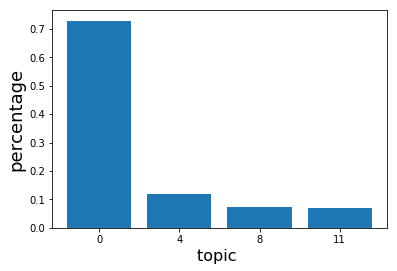

In [25]:
visulize_topic_dist('grundtvig11val_workid118888.txt')

#### Finding the dominant topic in each sentence

Here we present the topic modelling results to for each of the document we have, and we extract the most popular topic for each document

In [26]:
"""the following code will help to determine what topic a given document is about"""
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = row[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num = row[0][0]
        prop_topic = row[0][1]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [27]:
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus=corpus, texts=data)

In [28]:

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7284,"gud, liv, ei, aand, dit, død, kun, ord, verd, ...","No. 196.\n *)Jeg som et Barn mig glæde vil,Og ..."
1,1,7.0,0.3263,"herod, delphi, melodi, slagterbænk, guldsom, d...",HENRICH STEFFENS.VED Henrik Steffens' Død den ...
2,2,2.0,0.3687,"kong, kun, stor, hel, rom, kom, ogsaa, vel, ba...","No. 40\n .Verden er, som Man den tager,Herlig ..."
3,3,14.0,0.9286,"gud, ord, ei, hjert, kun, verd, aand, lys, dag...",No. 63\n . *)Paradis-Gaard og Folke-Vang!Synge...
4,4,8.0,0.5301,"gud, død, ei, kan, al, no, liv, ord, aand, vort","No. 327\n .Gud-Fader udsendte sit Naadens-Ord,..."
5,5,14.0,0.7348,"gud, ord, ei, hjert, kun, verd, aand, lys, dag...","No. 200\n .Guds Engle sang i Stjerne-Tal,Stjer..."
6,6,14.0,0.2906,"gud, ord, ei, hjert, kun, verd, aand, lys, dag...",No. 156\n . *)Stjernernes Skaber og Himmelens ...
7,7,10.0,0.3625,"dam, odin, thor, myth, asern, jet, lok, nord, ...","No. 119\n .Syng, Guds Folk! med Hjertens Glæde..."
8,8,17.0,0.7665,"glemmes_aldr, kvædl, syrith, willemo, himlensa...","No. 2\n .Adam og Eva\n .Ordet sig hviled,Engle..."
9,9,8.0,0.9027,"gud, død, ei, kan, al, no, liv, ord, aand, vort",No\n . 86.*)Mel.\n : Et Barn er født i Bethehe...


#### Find the most representative document for each topic

In [29]:
"""find the documents a given topic has contributed to the most and infer the topic by reading that document."""
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9328,"gud, liv, ei, aand, dit, død, kun, ord, verd, ...",No. 354.\n *)Sin Eenbaarne Gud hengivetHar for...
1,1.0,0.9229,"kan, aand, kirk, kun, maa, naar, ord, hel, tro...",DEN CHRISTELIGEBØRNELÆRDOM.DEN Række Afhandlin...
2,2.0,0.7049,"kong, kun, stor, hel, rom, kom, ogsaa, vel, ba...",HAANDBOG I VERDENSHISTORIEN. ANDEN DEEL.\n MID...
3,3.0,0.6854,"kong, ei, kom, dannemark, kun, gaml, søn, ord,...","No. 211\n . *)Med sin Alabaster-Krukke,Fuld af..."
4,4.0,0.5208,"jordensaa, rethan, tidsom, givetat, tilbage, s...","No. 38\n .Christne, med Skiel,Kaldes de vel,Al..."


#### Topic distribution across documents

understand the volume and distribution of topics in order to judge how widely it was discusse

In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords= topic_num_keywords.drop_duplicates(subset=['Dominant_Topic', 'Topic_Keywords'])

#Merge the quitity into a single table by topic number
temp = pd.DataFrame(topic_counts).reset_index()
temp.columns = ['Dominant_Topic','Num_Documents']
temp2 = pd.DataFrame(topic_contribution).reset_index()
temp2.columns = ['Dominant_Topic','Perc_Documents']
temp3 = pd.merge(topic_num_keywords, temp, on="Dominant_Topic")
df_dominant_topics=pd.merge(temp3, temp2, on="Dominant_Topic")

# Show
df_dominant_topics.sort_values(by=['Perc_Documents']).reset_index()

,index,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,13,9.0,"odin, asern, jet, digt, lok, aser, norn, gud, ...",3,0.0043
1,5,10.0,"dam, odin, thor, myth, asern, jet, lok, nord, ...",5,0.0072
2,18,19.0,"dansk, bønd, danmark, slesv, fru_mari, modersm...",6,0.0086
3,2,2.0,"kong, kun, stor, hel, rom, kom, ogsaa, vel, ba...",6,0.0086
4,16,15.0,"canaan, aandtil, kvær, haandsaa, stigeop, raha...",6,0.0086
5,6,17.0,"glemmes_aldr, kvædl, syrith, willemo, himlensa...",8,0.0115
6,14,4.0,"jordensaa, rethan, tidsom, givetat, tilbage, s...",10,0.0144
7,8,13.0,"korsets_træ, blaamænd, sagog, korsfæstedenu, v...",10,0.0144
8,1,7.0,"herod, delphi, melodi, slagterbænk, guldsom, d...",11,0.0158
9,10,6.0,"liv, herm, boemund, antioki, glemmes_aldr, apo...",13,0.0187
